In [2]:
import os
import sncosmo
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from corner import corner

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

In [4]:
data_path = '/home/samdixon/jla_light_curves/'

In [53]:
fname = 'lc-05D2ah.list'
lc = sncosmo.read_lc(os.path.join(data_path, fname), format='salt2', expand_bands=True, read_covmat=True)

# Fixed redshift

In [54]:
model = sncosmo.Model(source='snemo7')
z = lc.meta['Z_HELIO']
bounds = {}
try:
    t0 = float(lc.meta['DayMax'].split()[0])
    bounds['t0'] = (t0-5, t0+5)
except KeyError:
    t0 = np.mean(lc['Date'])
    bounds['t0'] = (min(lc['Date'])-20, max(lc['Date']))
for param_name in model.source.param_names[1:]:
    bounds[param_name] = (-100, 100)
model.set(z=z, t0=t0)
minuit_result, minuit_fit_model = sncosmo.fit_lc(lc,
                                                 model,
                                                 model.param_names[1:],
                                                 phase_range=(-10, 40))
emcee_result, emcee_fit_model = sncosmo.mcmc_lc(sncosmo.select_data(lc, minuit_result['data_mask']),
                                                minuit_fit_model,
                                                model.param_names[1:],
                                                guess_t0=False,
                                                bounds=bounds,
                                                warn=False,
                                                nwalkers=20)

/home/samdixon/miniconda3/lib/python3.6/site-packages/sncosmo-1.6.0-py3.6-linux-x86_64.egg/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: megacampsf::z at 11.212149(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


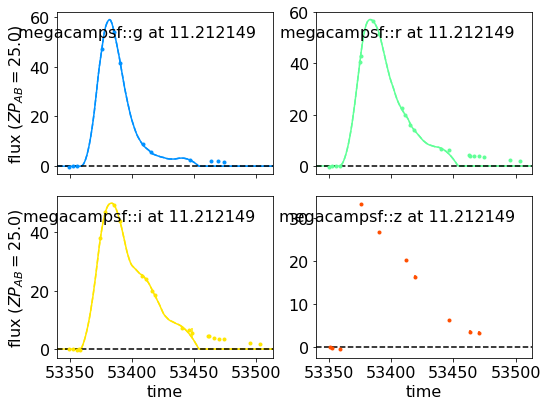

In [55]:
sncosmo.plot_lc(lc, [emcee_fit_model, minuit_fit_model]);

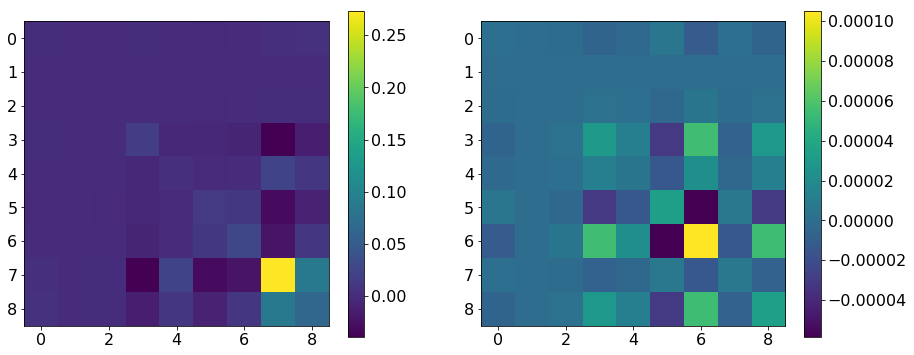

In [56]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(emcee_result.covariance)
plt.colorbar()
plt.subplot(122)
plt.imshow(minuit_result.covariance)
plt.colorbar()

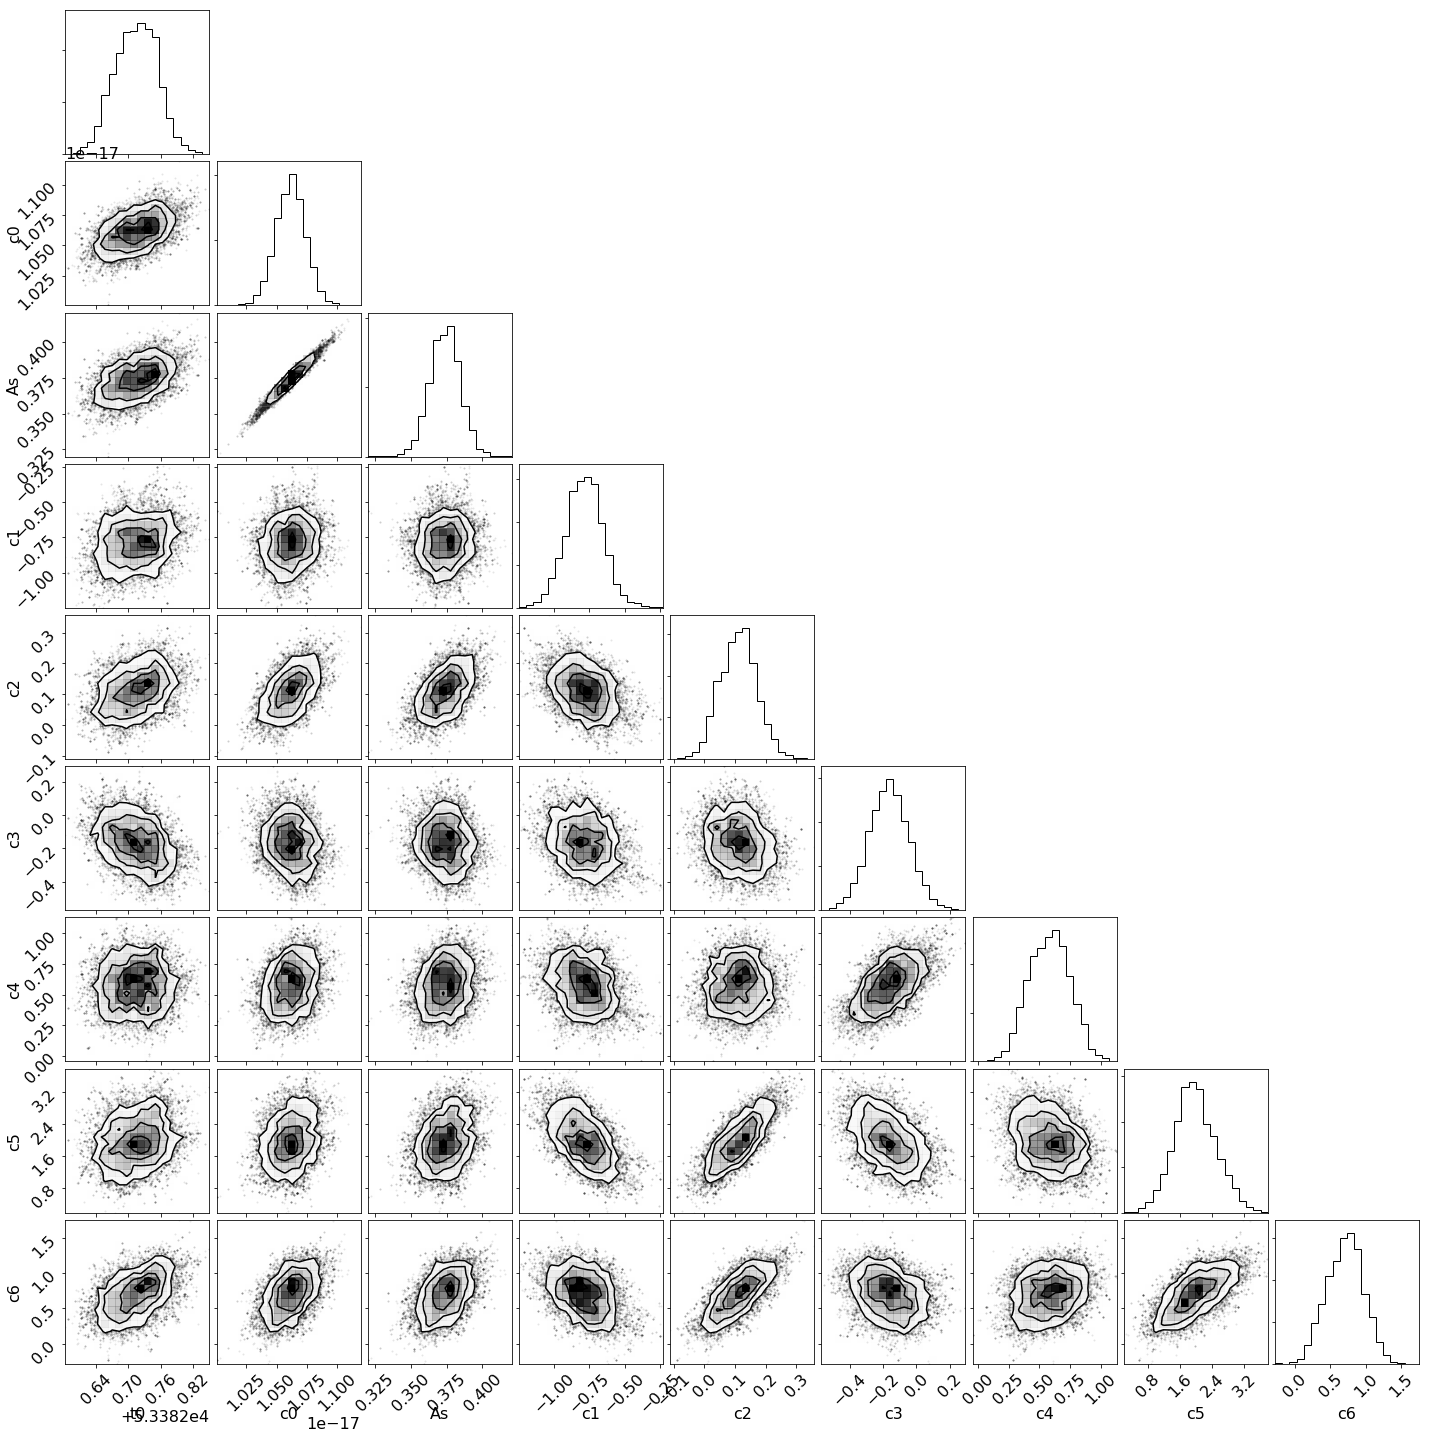

In [57]:
corner(emcee_result.samples, labels=model.param_names[1:]);

In [25]:
emcee_result.samples.shape

(20000, 9)

In [58]:
def gelman_rubin(chain):
    ssq = np.var(chain, axis=1, ddof=1)
    W = np.mean(ssq, axis=0)
    θb = np.mean(chain, axis=1)
    θbb = np.mean(θb, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1) * np.sum((θbb - θb)**2, axis=0)
    var_θ = (n - 1) / n * W + 1 / n * B
    R̂ = np.sqrt(var_θ / W)
    return R̂

In [66]:
gelman_rubin(emcee_result.samples[:10])

0.9428090415826804